# IMDB

In [1]:
#NLP自然語言處理這次不是分類圖片，而是分類文檔。
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#不再是引用fastai.vision，這次我們引用fastai.text。這裡面你可以找到所有的專門用來分析文本文檔的東西。
from fastai.text import *

## Preparing the data

First let's download the dataset we are going to study. The [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

We'll begin with a sample we've prepared for you, so that things run quickly before going over the full dataset.

In [ ]:
"這個例子裡，我們要用一個叫IMDB的數據集。 IMDB裡有很多電影評論。一般是兩三千個單詞。每個評論被分為正面的或者負面的。"

In [3]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[WindowsPath('C:/Users/User/.fastai/data/imdb_sample/texts.csv')]

It only contains one csv file, let's have a look at it.

In [4]:
"我們可以使用pandas.read來讀取csv文件"
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [5]:
"內容如下"
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code:

In [6]:
"我們可以使用factory methods或者data block API來創建data bunch。這是一個從CSV文本文件中創建data bunch的快速方法。"
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A `TextDataBunch` does all of that behind the scenes for you.

Before we delve into the explanations, let's take the time to save the things that were calculated.

In [7]:
data_lm.save()

Next time we launch this notebook, we can skip the cell above that took a bit of time (and that will take a lot more when you get to the full dataset) and load those results like this:

In [8]:
data = load_data(path)

### Tokenization

In [ ]:
"分詞（Tokenization）: 它處理這些單詞，把它們轉成標準的token（分詞）。基本上每個token代表一個單詞。"

The first step of processing we make the texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [9]:
data = TextClasDataBunch.from_csv(path, 'texts.csv')
data.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , steaming bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj sydney , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i dreaded a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj yorkers . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos i really wanted to love this show . i truly , honestly did . \n \n xxmaj for the first time , gay viewers get their own version of the "" xxmaj the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance",negative
"xxbos \n \n i 'm sure things did n't exactly go the same way in the real life of xxmaj homer xxmaj hickam as they did in the film adaptation of his book , xxmaj rocket xxmaj boys , but the movie "" xxmaj october xxmaj sky "" ( an xxunk of the book 's title ) is good enough to stand alone . i have not read xxmaj",positive


In [ ]:
"""它做了一些這樣的事情，看到沒有，“didn't” 被轉成裡兩個獨立的單詞（did 和 n't）。並且所有的內容都被轉成小寫了。
   看到“you're”被轉成兩個獨立的單詞（you 和're）了嗎? 分詞（Tokenization）是要讓每個“token”（每個詞兩邊都有空白）代表一個獨立的語義。
   它遇到特別少見的單詞（比如說名字）時，會把它們用一個叫unknown （xxunk）專門的token替代。在fastai裡所有以 xx 開頭的都是特殊token。
   這就是Tokenization，所以我們最後可以得到一個被分詞過的單詞的列表。你也能看到標點周圍也被加了空格，來保證它們是單獨的token。
"""

The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like this: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unknown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization

In [ ]:
"編號（Numericalization）"

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids to tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [10]:
"""下一步是為所有可能的token創建一個完整的唯一的列表，這被叫做vocab單詞表。
    data.vocab.itos[:10]
    ['xxunk', 'xxpad', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']
    這是所有電影評論裡最常出現的token（前十個）。然後我們用一個數字列表來替代每個電影評論。
    data.train_ds[0][0].data[:10]
    array([ 43, 44, 40, 34, 171, 62, 6, 352, 3, 47])
    這個列表裡的數字代表這個位置上的分詞在單詞表裡的序號。
    
    @分詞（Tokenization）和編號（Numericalization），是NLP裡把文檔轉成一個數字list的標準方式。@
"""
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [11]:
data.train_ds[0][0]

Text xxbos xxmaj want to watch a scary horror film ? xxmaj then steer clear of this one . xxmaj there 's not enough beer in the world to make this film enjoyable . 
 
  xxmaj however , there is enough scotch . xxmaj single - xxunk , if you can manage it . 
 
  xxmaj if the previous comments were n't enough to keep you from watching this film sober , allow me to assist . xxup nasa sends one man and two xxunk extras into space to orbit xxmaj saturn . a really big xxunk xxunk causes xxmaj colonel xxmaj steve xxmaj west to bleed from the nose . xxmaj things go downhill from there , and wackiness ensues . 
 
  i actually read the book adaptation , which was published and released only in the xxup uk . xxup miles better than the film , and the book was dreadful . xxmaj at least some pretense is made towards suspense , and some sort of explanation of events is pulled out from the author 's ( xxunk with ' gas ' ) . 
 
  xxmaj not to say that the film is completely without merit . xxmaj rick xx

But the underlying data is all numbers

In [12]:
data.train_ds[0][0].data[:10]

array([  2,   5, 196,  15, 126,  13, 673, 206,  32,  67], dtype=int64)

### With the data block API

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the various arguments to pass will appear in the step they're revelant, so it'll be more readable.

In [13]:
"""我們用data block API:
   這次，不再用ImageFilesList，而是從CSV創建一個TextList，創建一個data bunch。這時我們可以開始創建一個模型了。
"""
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

In [ ]:
"""做NLP分類時我們會創建兩個模型：
   第一個模型叫 語言模型（language model）(第14行~33行)我們用普通的方式訓練
   (第21行)learn = language_model_learner(data_lm,pretrained_model=URLs.WT103, drop_mult=0.3)
   我們創建一個language model learner，訓練它，保存它，解凍，再訓練。
   
   在我們創建語言模型之後，我們創建分類器（classifier）(第34行~56行)。
   我們創建classifier的data bunch，創建一個 learner，訓練它，得到準確率。
   
   這裡快速講下。下週我們會講更多細節。你可以看到訓練NLP分類器的基本思路和我們之前的創建其他模型的思路是很相似的。
   目前IMDB分類的最好成績（state of the art）是我們和一個叫Sebastian Ruder的同事一起創造、發表的。
   剛剛演示的基本就是取得最好成績的算法，裡面還有些其它的小技巧。如果你努力嘗試，你可以達到95%。這很接近我們得到的最好成績。
"""

## Language model

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [14]:
bs=48

Now let's grab the full dataset for what follows.

In [16]:
path = untar_data(URLs.IMDB)
path.ls()

A new version of the dataset is available.


[WindowsPath('C:/Users/User/.fastai/data/imdb/imdb.vocab'),
 WindowsPath('C:/Users/User/.fastai/data/imdb/README'),
 WindowsPath('C:/Users/User/.fastai/data/imdb/test'),
 WindowsPath('C:/Users/User/.fastai/data/imdb/tmp_clas'),
 WindowsPath('C:/Users/User/.fastai/data/imdb/tmp_lm'),
 WindowsPath('C:/Users/User/.fastai/data/imdb/train'),
 WindowsPath('C:/Users/User/.fastai/data/imdb/unsup')]

In [17]:
(path/'train').ls()

[WindowsPath('C:/Users/User/.fastai/data/imdb/train/labeledBow.feat'),
 WindowsPath('C:/Users/User/.fastai/data/imdb/train/neg'),
 WindowsPath('C:/Users/User/.fastai/data/imdb/train/pos'),
 WindowsPath('C:/Users/User/.fastai/data/imdb/train/unsupBow.feat')]

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder on top of `train` and `test` that contains the unlabelled data.

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word is, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews left by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust the parameters of our model by a little bit. Plus there might be some words that would be extremely common in the reviews dataset but would be barely present in wikipedia, and therefore might not be part of the vocabulary the model was trained on.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

In [18]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [19]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [20]:
data_lm.show_batch()

idx,text
0,"later , by which time i did not care . xxmaj the character we should really care about is a very cocky , overconfident xxmaj ashton xxmaj kutcher . xxmaj the problem is he comes off as kid who thinks he 's better than anyone else around him and shows no signs of a cluttered closet . xxmaj his only obstacle appears to be winning over xxmaj costner . xxmaj"
1,"happening up , close & personal . xxmaj what appears on screen is mostly the aftermath of the killer 's vengeance : one fellow holding his guts , another with a xxunk up the group 's volleyball net ) plunged through his chest , blood spatter after a woman gets hit over the head presumably with a large rock , one chick laying dead after the scarecrow hit her with"
2,"xxmaj johnny xxmaj sokko ( ? ) , a young boy who controls a xxmaj giant xxmaj robot , and his fight against the evil xxmaj gargoyle xxmaj gang , who seem to have an endless supply of horrid giant monsters at their disposal . xxbos xxmaj watching this movie brings several words to mind : "" sophomoric "" , "" ridiculous "" , "" improbable "" , "" self"
3,"america . xxmaj no mention that a lot of people have died . \n \n xxmaj then there 's xxmaj michael xxmaj clarke xxmaj duncan . a wonderful actor , wasted . xxmaj never has a black man been so token . xxmaj among a team of hardcore drillers , his job seems to consist of standing in the back , occasionally saying "" xxmaj hey , you da"
4,"still not sure it was worth it ... xxbos xxmaj let me say at the outset that i 'm not a very artistic person and that i do n't "" get "" new art . xxmaj that being said , this film is absolutely crazy , and in my opinion not crazy in a good way . xxmaj filmed entirely in black and white with a series of very loosely"


We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

In [21]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


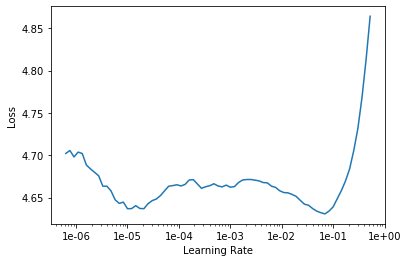

In [23]:
learn.recorder.plot(skip_end=15)

In [24]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.137822,4.020172,0.295707,21:04


In [25]:
learn.save('fit_head')

In [26]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [27]:
learn.unfreeze()

In [28]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.844263,3.813834,0.317698,24:45
1,3.802978,3.772527,0.324902,25:30
2,3.793264,3.741329,0.329563,24:53
3,3.719896,3.705808,0.333661,25:25
4,3.671008,3.675662,0.336757,24:39
5,3.609677,3.649988,0.339925,24:50
6,3.494647,3.631659,0.342422,25:10
7,3.481280,3.619783,0.344014,25:14
8,3.409071,3.617496,0.344400,24:01
9,3.381227,3.619449,0.344422,1:21:56


In [29]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [30]:
learn.load('fine_tuned');

In [31]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [32]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because i really liked the first part of the film . It was very entertaining . It was not put in on the same earth as the first movie . The acting was great . The movie
I liked this movie because of the other actors . i love Ben Stiller and Jack Black . They were just great . They both add a lot of class to this movie . And , of course


We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [33]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [34]:
path = untar_data(URLs.IMDB)

In [36]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [37]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [38]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj the vigilante has long held a fascination for audiences , inasmuch as it evokes a sense of swift , sure justice ; good triumphs over evil and the bad guy gets his deserts . xxmaj it is , in fact , one of the things that has made the character of xxmaj dirty xxmaj harry xxmaj callahan ( as played by xxmaj clint xxmaj eastwood ) so popular",pos
"xxbos xxup spoilers xxup herein \n \n xxmaj my xxmaj high xxmaj school did all they could to try and motivate us for exams . xxmaj but the most memorable method they used to get us into the right state of mind was a guest speaker , who was none other than xxmaj australian xxmaj kickboxing 's favorite son , xxmaj stan "" xxmaj the xxmaj man "" xxmaj",neg
"xxbos xxmaj anyone who visited drive - ins in the 1950s , 60s , and 70s , must have seen a film or two by xxmaj american xxmaj international xxmaj pictures , a distributor that resembled 1980s giant xxmaj cannon xxmaj films . xxmaj wherever movie - goers ventured , xxup aip would be right there to supply the latest en vogue titles - in the 50s came horror movies",neg
"xxbos xxup oliver xxup twist was to have controversy as well as success following it after xxmaj dickens published it in 1837 . xxmaj his picture of life in the urban ghettos was something shocking and new , and his making the central figures of the novel include criminals was another innovation . \n \n xxmaj one day he was walking in xxmaj london and passed a young woman",pos


We can then create a model to classify those reviews and load the encoder we saved before.

In [39]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxmaj story of a man who has unnatural feelings for a pig . xxmaj starts out with a opening scene that is a terrific example of absurd comedy . a formal orchestra audience is turned into an insane , violent mob by the crazy xxunk of it 's singers . xxmaj unfortunately it stays absurd the xxup whole time with no general narrative eventually making it just too off putting . xxmaj even those from the era should be turned off . xxmaj the cryptic dialogue would make xxmaj shakespeare seem easy to a third grader . xxmaj on a technical level it 's better than you might think with some good cinematography by future great xxmaj vilmos xxmaj zsigmond . xxmaj future stars xxmaj sally xxmaj kirkland and xxmaj frederic xxmaj forrest can be seen briefly .,xxbos xxmaj airport ' 77 starts as a brand new luxury 747 plane is loaded up with valuable paintings & such belonging to rich businessman xxmaj philip xxmaj steven

In [40]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


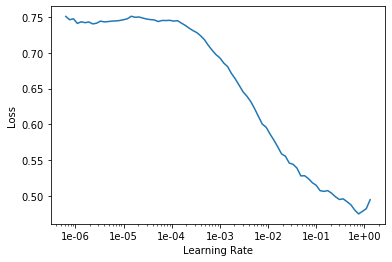

In [41]:
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.279292,0.178286,0.932880,05:15


In [43]:
learn.save('first')

In [44]:
learn.load('first');

In [45]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.230728,0.164024,0.938800,05:43


In [46]:
learn.save('second')

In [47]:
learn.load('second');

In [48]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.195398,0.143161,0.948720,06:46


In [49]:
learn.save('third')

In [50]:
learn.load('third');

In [55]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


RuntimeError: CUDA out of memory. Tried to allocate 91.63 MiB (GPU 0; 11.00 GiB total capacity; 8.44 GiB already allocated; 29.22 MiB free; 201.86 MiB cached)

In [56]:
learn.predict("I really loved that movie, it was awesome!")

C:\Users\User\Anaconda3\envs\fastai_v1\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category pos, tensor(1), tensor([7.2650e-05, 9.9993e-01]))

In [ ]:
"""提問: 對於不同於ImageNet的數據集，比如說衛星圖或者生物圖，我們應該使用我們自己的統計分佈（stats）。
Jeremy 說過：
如果你使用預訓練的模型，你需要使用和預訓練相同的stats。
這是為什麼？是不是使用自己的stats標準化的模型有和ImageNet基本一樣的分佈？唯一我能想到的不同的地方是偏度（skewness）。
你這麼說是因為偏度還是其他的東西？這是否代表對於差別比較大的數據集你不推薦使用預訓練模型？ 


不是。你可以看到，我在所有的地方都用了預訓練模型。每次我用ImageNet預訓練模型時，我都使用ImageNet stats。為什麼呢？因為模型是用這些stats訓練的。
比如說，假如你在分類不同品種的綠青蛙。
如果你使用自己數據集每個channel（紅藍綠）均值，你最終會把它們轉換成在每個channel上服從均值為0標準差為1的分佈。
這意味者它們不再像綠青蛙了。而是像灰青蛙。但是ImageNet希望青蛙是綠的。所以你需要用ImageNet訓練者使用的stats做標準化。
否則你的數據集的唯一特徵會不見，你在做標準化時把它們丟失了。所以你需要使用和訓練時相同的stats。
每個例子裡我們都是用mini batch做梯度下降（隨機梯度下降）來擬合模型參數。這些參數是用來做矩陣乘法的。
這個課程的後半部分裡，我們會學習卷積，這也是一種矩陣乘法。
儘管沒有矩陣乘法運算可以創建出這樣的東西：可以識別電影評論是正面還是負面、看出衛星圖識別出上面有沒有道路。
這遠遠不是線性分類器可以做到的。現在我們知道這是深度神經網絡。深度神經網絡包含很多這樣的矩陣乘法，每個矩陣乘法運算都是一個線性分類器。
一個線性函數在另一個的上層。如果你回憶高中數學，你可能會記得如果你有一個y=ax+b，然後在它上面做cy+d ，
它還是一個有不同斜率和截距的線性函數。所以矩陣乘法運算不會有任何幫助。

這些模型實質上是什麼呢？我們實質上在做什麼？這是個有意思的事情：
我們確實做了矩陣乘法運算（或者像卷積這樣的變種），但每做一次矩陣乘法後，我們會做一次非線性計算或者叫激活函數。
激活函數把矩陣乘法的結果作為輸入，在上面做些處理。這是一些我們用到的激活函數 (by Sagar Sharma):
以前，最常用的函數是sigmoid。它們有特定的數學定義。現在我們幾乎不用這個了。
我們現在是用rectified linear unit (ReLU)。當你做深度學習時，用很大很長的、引人注意的詞很重要。
否則普通人會覺得他也可以做。但是，只告訴你們，rectified linear unit是用這樣的函數定義的:
max(x, 0)
就是這樣。如果你想高大上些，你可以用縮寫ReLU，來顯示你在一個高大上的團隊裡。這就是ReLU激活函數。
這是神奇的事情。如果你把紅綠藍像素值輸入，做矩陣乘法運算，把負值用0替代，做另外一個矩陣運算，把負值用0替代，你不停地這樣做，就能得到一個神經網絡。就是這樣而已
"""

In [ ]:
http://neuralnetworksanddeeplearning.com
http://neuralnetworksanddeeplearning.com/chap4.html
"""通用逼近定理Universal approximation theorem 

這是怎樣做到的呢？一個特別酷的叫Michael Nielsen的傢伙展示了他的作品。
他有一個很好的網站（實際上是一本書） http://neuralnetworksanddeeplearning.com ，上面有這些美妙的JavaScript的控件，你可以在上面做操作。
因為這是以前做的，以前我們一般用sigmoids激活函數。他演示了，如果你做足夠的矩陣乘法運算，然後用sigmoids處理（用ReLU也是完全一樣的），
你可以創建出任意函數。這個線性函數和非線性函數的組合可以創建任意形狀的理論被稱作通用逼近定理。

它說的是，如果你有一批線性函數和非線性函數，它們最終可以無限逼近任何函數。
所以你只需要保證你有足夠大的或者足夠多的矩陣來做乘法運算。
如果這個函數是由一批線性函數和非線性函數構成的，非線性函數可以是這些激活函數里的任何一個，
如果它可以逼近任何函數，你需要做的就是找出這些做乘法的權重矩陣的值，這些矩陣相乘可以解決你要處理的問題。
我們已經知道了怎樣找到參數的值。我們可以用梯度下降。就是這樣。

我發現最難向學生們解釋的事情是：我們現在已經學完了。人們總是在課後來問我“其餘的是什麼，請解釋下深度學習的其餘的內容”。
但是，沒有其餘的了。我們有一個函數可以接收像素或者其他的東西，我們用一些矩陣和輸入值相乘，把負值替換成0，
我們再用另一個矩陣乘以它，把負值替換成0，多做幾次。我們看看它裡我們的目標有多近，然後按照梯度下降方法，用導數更新參數，多做幾次。
最終，我們得到了可以分類電影評論或者可以識別布偶貓（ragdoll cat）的程序。就是這樣。

這很難直觀地理解的原因是，我們講的矩陣是有上億個參數的（把所有的加起來）。它們是非常大的矩陣。
對於多次用一個線性模型乘以一些東西，把負值替換成零這樣一個操作能做些什麼，你的直覺處理不了。你只能根據經驗來接受這個現實：這樣的操作很有效。

在課程的第二部分，我們會從頭開始實現這些。但是提前講下，你會發現它們就是5行代碼。
就是一個for循環，裡面運行t = x @ w1 , t2 = max(t, 0) , 再用一個for循環執行所有的矩陣，最後計算損失函數。
當然，我們不會自己計算梯度，因為PyTorch為我們做了這些。就是這樣。
"""

In [ ]:
"""提問: 有一個關於分詞的問題。我比較好奇分詞是怎樣做到處理詞組的，比如說San Francisco 

怎樣對San Francisco這樣的東西做分詞。 San Francisco包含兩個token 就是San一個而Francisco一個。就是這樣。這就是怎樣對 San Francisco做分詞。
這個問題可能是做過傳統NLP的人提的，他們經常要用叫n-grams的東西。 N-rams是基於線性模型計算像San Francisco這樣的特定的文本字符串出現多少次。
當n等於2時，n-grams就是bi-gram 。使用深度學習，我們不用再考慮這個，這很酷。像很多其它東西一樣，有了深度學習後，很多複雜的特徵工程用不上了。
使用深度學習，每個token只是一個單詞（對you're這種實際上包含兩個詞的情況，你把它分成兩個單詞），
然後我們要做的就是讓深度學習模型找出組合單詞的最好方法。現在，當我們說讓深度學習模型找出它來的時候，
我們指的當然就是使用梯度下降找出能給出正確答案的權重矩陣。沒有其他的內容。

另外，有些小技巧。在後半部分，我們會學習針對圖像模型的技巧，使用卷積，讓它成為CNN，針對語言模型的技巧是使用遞歸模型或者叫RNN。
和剛才講的相比較，這都是次要的技巧。使用RNN，它可以學到當San和Francisco這兩個詞在一起時，會有不同的含義。
"""

In [ ]:
"""提問: 一些衛星圖有4個通道。怎樣用預訓練模型處理4通道的數據或者2通道的數據？

我想這是我們要嘗試並集成到fastai裡的東西。希望你們看到這個課程視頻時，會有做到這個的簡單方方法。
預訓練的ImageNet模型接收紅綠藍像素。如果你只有兩個通道，你可以做一些事情，基本上就是多構造一個通道。
可以讓這個通道裡的值都是0，或者是另外兩個通道的平均值。你可以使用普通的PyTorch運算來創建這樣一個通道。
你可以提前在循環裡構造，保存一個三通道的版本，也可以根據需要創建一個定制的數據集。

對於4通道的情況，你可能不希望捨棄第四個通道。
所以你需要修改模型，在後面幾節課裡，我們會知道怎樣做。
基本上是對於初始權重矩陣（權重矩陣是不准確的，應該叫權重張量weight tensors，因為有多個維度），
它的一個軸上要有三個slice（切片），我們會用0或者隨機數初始化它們。簡單講就是這樣，但是要理解究竟這是什麼意思，我們還要再多花兩節課。
"""

In [ ]:
使用和單標籤分類相同的方法，我們可以做這些事情，這很酷：

做多標籤分類，
比如處理planet數據集
圖像分割
各種圖像回歸
NLP分類很多其他的

每個任務裡，我們實際上做的都是：

梯度下降
非線性處理

通用逼近定理告訴我們，它能幾乎無限逼近任何給定的函數，比如這些：

把說話的聲音轉化成這個人說的內容把日語的句子轉換成英語的句子把一個狗的圖片轉換成一段描述狗的文字

這些都是我們可以用這個方法學習的數學函數。

比如多標籤分類、圖像回歸、圖像分割，或者其他類型的東西，試試你是不是能解決這個問題。
你可能會發現最難的部分是創建data bunch，所以你需要深入學習data block API，學會怎樣用你的數據創建出data bunch。
做些練習，你就會很擅長了。這不是一個很大的API，只有幾個部分。要添加你自己的方法也很容易。如果在嘗試時遇到了問題，就在論壇上提問。